# Setup

In [22]:
#install.packages("odbc")
#install.packages("DBI")
#install.packages("rstudioapi")

library(odbc)
library(dplyr)
library(stringr)
library(tidyr)
library(tidyverse)
library(ggplot2)
library(e0171)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ purrr     1.0.2
✔ ggplot2   3.5.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ tibble    3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


ERROR: Error in library(e0171): there is no package called ‘e0171’


In [ ]:
#install.packages("eeptools") # to calculate ages
#install.packages("apaTables")
#install.packages("tableone")


In [ ]:
system("sudo su -c 'curl https://packages.microsoft.com/config/rhel/7/prod.repo > /etc/yum.repos.d/mssql-release.repo && exit'")
system("sudo yum remove unixODBC-utf16 unixODBC-utf16-devel")
system("sudo ACCEPT_EULA=Y yum install -y msodbcsql17")
system("sudo ACCEPT_EULA=Y yum install -y mssql-tools")
system("echo 'export PATH='$PATH:/opt/mssql-tools/bin'' >> ~/.bashrc")
system("source ~/.bashrc")
system("sudo yum install -y unixODBC-devel")

In [ ]:
file_path <- '/home/ec2-user/SageMaker/db-credentials.txt'
db_creds_df <- read.table(file_path)
db_creds <- db_creds_df$V3
names(db_creds) <- db_creds_df$V1
db_creds <- trimws(db_creds)
#db_creds

In [ ]:
# load database
db <- 'S35'

In [ ]:
connection_string = paste0("DRIVER={ODBC Driver 17 for SQL Server};",
                          "SERVER=", db_creds['host'], ',', db_creds['port'], ';',
                          "DATABASE=", db, ';',
                          "UID=", db_creds['username'], ';',
                          "PWD={", db_creds['password'], "};")

#connection_string

In [ ]:
db_conn <- DBI::dbConnect(odbc::odbc(), .connection_string = connection_string)

# ICD names

Loading ICD names to join to datasets and filter using keywords

In [ ]:
icdnames<-dbGetQuery(db_conn, "select * from S35.dbo.ICDnames;")
icdnames<-icdnames %>% select(-CONCEPT_PATH)

# DEMOGRAPHICS

In [122]:
#select patient demographics (subsample of 100 pts)
demo<-dbGetQuery(db_conn,"select * from S35.dbo.phqdemographics;")


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'conn' in selecting a method for function 'dbGetQuery': object 'db_conn' not found


Selecting only on the Phq-9 which is PRO:ADV0014. PRO:ADV0045 is the PHQ-2. Specificty isn't quite as high as the PHQ9 but there are far more administered.

# Coding the factor levels for Demographic Variables

In [ ]:
demo %>% head()

In [ ]:
library(haven)
library(purrr)
library(apaTables)

In [ ]:
complete.demo<-complete.df %>% as.matrix() %>% as.data.frame() %>% mutate(
    BIRTH_DATE=as_date(BIRTH_DATE),
    AdminDate=as_date(AdminDate),
Age=age_calc(dob = BIRTH_DATE, enddate = AdminDate, units = "years"))  %>% 
mutate(FPL=case_match(CURRENT_FPL_CD,"DEM|FPL:<=100"~"FPL Below 100","DEM|FPL:151-200"~"FPL 151-200","DEM|FPL:UN"~"FPL Unknown","DEM|FPL:>200
"~"FPL Over 200", "DEM|FPL:101-150"~"FPL 101-150"),
 Marital=case_match(MARITAL_STATUS_CD,"DEM|MARITAL:Other"~"Other",
"DEM|MARITAL:Widowed"~"Widowed",
"DEM|MARITAL:Divorced"~"Divorced",
"DEM|MARITAL:Separated"~"Separated",
"DEM|MARITAL:Domestic Partner"~"Domestic Partner",
"DEM|MARITAL:Significant Other"~"Significant Other",
"DEM|MARITAL:Married"~"Married",
"DEM|MARITAL:Single"~"Single",
"DEM|MARITAL:NI"~"Marital NI"),
Gender=case_match(GENDER_CD,"DEM|GENDER:TG"~"Transgender",
"DEM|GENDER:GQ"~"Genderqueer",
"DEM|GENDER:UN"~"Unknown / Missing",
"DEM|GENDER:OT"~"Other",
"DEM|GENDER:M"~"Man",
"DEM|GENDER:W"~"Woman"),
Race=case_match(RACE_CD,"DEM|RACE:02"~"Asian",
"DEM|RACE:06"~"Multiple race",
"DEM|RACE:01"~"American Indian or Alaskan Native",
"DEM|RACE:05"~"White",
"DEM|RACE:03"~"Black or African American",
"DEM|RACE:07"~"Refuse to answer",
"DEM|RACE:04"~"Native Hawaiian or Other Pacific Islander",
"DEM|RACE:OT"~"Other"),
Rural=case_match(RURAL_CD,"DEM|RURAL:Y"~"Yes",
"DEM|RURAL:N"~"No"),
Sex=case_match(SEX_CD,"DEM|SEX:NI"~"Sex No Informatsuion",
"DEM|SEX:F"~"Female",
"DEM|SEX:M"~"Male",
"DEM|SEX:UN"~"Sex Unknown"),
Sexor=case_match(SEXORIENTATION_CD,"DEM|SEXORIENTATION:GA"~"Gay",
"DEM|SEXORIENTATION:SE"~"Something else",
"DEM|SEXORIENTATION:LE"~"Lesbain",
"DEM|SEXORIENTATION:ST"~"Straight",
"DEM|SEXORIENTATION:MU"~"Multiple sexual orientations",
"DEM|SEXORIENTATION:UN"~"Unknown/ Missing",
"DEM|SEXORIENTATION:BI"~"Bisexual",
"DEM|SEXORIENTATION:QU"~"Queer"))%>% 
mutate(across(c(HEALTH_SYSTEM_ID,CURRENT_FPL_CD:SEXORIENTATION_CD,FPL:Sexor),~factor(.)))


# PHQ

# CURRENT WORKING BAND

In [ ]:
phqcomplete<-dbGetQuery(db_conn,"select * from S35.dbo.phqcomplete;")

In [ ]:
## phqcomplete with depression or hyp filter
phqcomplete<-phqcomplete %>% left_join(icdnames)


In [ ]:
#playing with doing vitals in the dataset in one go to avoid merge problems
phqnewcols<-phqcomplete %>%  mutate(NAME_CHAR=
       case_when(
       str_detect(NAME_CHAR,"Depress")~"Depressed",
       str_detect(NAME_CHAR,"Type II|Type 2|Diabetes")~"Diabetes",
       str_detect(NAME_CHAR,"Hyperlipidemia")~"Hyperlipidemia",
       str_detect(NAME_CHAR,"Hypertens")~"Hypertension",
       str_detect(NAME_CHAR,"Obesity")~"Obesity"
       #.default=NAME_CHAR
       ))%>% mutate(Vitals=
      case_when(
       str_detect(CONCEPT_CD,"BMI")~"BMI", 
       str_detect(CONCEPT_CD,"SYS")~"SystolicBP", 
       str_detect(CONCEPT_CD,"DIAS")~"DiastolicBP",
       str_detect(CONCEPT_CD,"PRO:ADV0039")~"Audit",
       str_detect(CONCEPT_CD,"PRO:ADV0045")~"Phq2",
      )) 

In [ ]:
phqcomplete %>% group_by(NAME_CHAR) %>% tally() %>% arrange(desc(n)) %>% write.csv("ConditionTally.csv")

In [52]:
phqalldx %>% filter(TVAL_CHAR=="Encounter Diagnosis") %>% group_by(phqPT,NAME_CHAR,phqEnc) %>% tally() %>% arrange(desc(phqEnc))

phqPT,NAME_CHAR,phqEnc,n
<int>,<chr>,<int>,<int>
10981548,Hypertension,245786550,1
10981335,Anxiety,245786399,1
10981335,Obesity,245786399,1
10981635,Bipolar,245779166,1
10981635,NA,245779166,1
10981230,Depressed,245777266,1
10981230,SUD,245777266,1
10981285,Depressed,245773709,1
10981629,NA,245772402,1


In [ ]:
# ALTERNATIVE VERSION THAT INCLUDES OTHER DIAGNOSES IN THE SAMPLE
phqalldx<-phqcomplete %>%  mutate(NAME_CHAR=
       case_when(
       str_detect(NAME_CHAR,"Depress|Dysthymic")~"Depressed",
       str_detect(NAME_CHAR,"Type II|Type 2|Diabetes")~"Diabetes",
       str_detect(NAME_CHAR,"Hyperlipidemia")~"Hyperlipidemia",
       str_detect(NAME_CHAR,"Hypertens")~"Hypertension",
       str_detect(NAME_CHAR,"Obesity")~"Obesity",
       str_detect(NAME_CHAR,"Adjustment")~"Adjustment",      
       str_detect(NAME_CHAR,"Anxiety|Panic|Agoraphobia")~"Anxiety",
       str_detect(NAME_CHAR,"Posttraumatic|Post-traumatic")~"PTSD",
       str_detect(NAME_CHAR,"Sleep|Insomnia|F51")~"Sleep",
       str_detect(NAME_CHAR,"Bipolar|Manic")~"Bipolar",
       str_detect(NAME_CHAR,"Nicotine|Tobacco")~"Tobacco",
       str_detect(NAME_CHAR,"Opioid|F11|F12|F13|F14|F15|F16|F18|F19")~"SUD",
       str_detect(NAME_CHAR,"Alcohol|F10")~"Alcohol",
       str_detect(NAME_CHAR,"Schiz|Delusional|F23|F24|F25|F28|F29")~"SchizophreniaSpectrum",     
       str_detect(NAME_CHAR,"Eating|F50")~"EatingDisorders"    
       #.default=NAME_CHAR
       ))%>% mutate(Vitals=
      case_when(
       str_detect(CONCEPT_CD,"BMI")~"BMI", 
       str_detect(CONCEPT_CD,"SYS")~"SystolicBP", 
       str_detect(CONCEPT_CD,"DIAS")~"DiastolicBP",
       str_detect(CONCEPT_CD,"PRO:ADV0039")~"Audit",
       str_detect(CONCEPT_CD,"PRO:ADV0045")~"Phq2",
      )) 

In [ ]:
#Save file from above in case the kernal crashes
save(phqalldx,file="phqalldx.RData")

In [20]:
load('/home/ec2-user/SageMaker/phqalldx.RData')

In [ ]:
# Reducing the size of the dataset for pivoting
phqfewercols<-phqalldx  %>%  filter(str_detect(CONCEPT_CD,"ICD|ADV0014|ADV0045|ADV0039|BMI|SYS|DIAS"))

In [ ]:
phqfewercols %>% nrow() #14921844

In [ ]:
evenphqfewer<-phqfewercols %>% filter(PhqScore>=10|PhqScore<=4) #limiting to phq extremes to run

In [ ]:
evenphqfewer %>% nrow()

In [ ]:
# rearranging data into wide format: the vitals. formerly phqfewer here
phqwide<-phqfewercols %>% unique() %>% mutate(n=1) %>% 
select(n,phqPT,PhqScore,phqEnc,AdminDate,TVAL_CHAR,NAME_CHAR,INSTANCE_NUM,CONCEPT_CD,NVAL_NUM,HEALTH_SYSTEM_ID,PROVIDER_ID,Vitals)%>% pivot_wider(names_from=Vitals,values_from=NVAL_NUM) 

In [ ]:
save(phqwide,file="wide_vitals.RData")

In [93]:
load('/home/ec2-user/SageMaker/wide_vitals.RData')

In [ ]:
#checking data integrity
phqwide %>% filter(Audit>1)

In [94]:
# rearranging wide icd codes
phqwide<-phqwide%>% 
select(n,phqPT,PhqScore,phqEnc,AdminDate,NAME_CHAR,INSTANCE_NUM,CONCEPT_CD,HEALTH_SYSTEM_ID,PROVIDER_ID,BMI,SystolicBP,DiastolicBP,Audit,Phq2) %>% pivot_wider(names_from=NAME_CHAR,values_from=n)

In [95]:
save(phqwide,file="phqwide_icd_fixed.RData")

In [ ]:
# integrity check again
phqwide %>% filter(Depressed==1)

In [98]:
phqwide %>% filter(!is.na(PTSD))

phqPT,PhqScore,phqEnc,AdminDate,INSTANCE_NUM,CONCEPT_CD,HEALTH_SYSTEM_ID,PROVIDER_ID,BMI,SystolicBP,⋯,Anxiety,Alcohol,Sleep,SUD,Tobacco,SchizophreniaSpectrum,Adjustment,EatingDisorders,Hypertension,PTSD
<int>,<dbl>,<int>,<dttm>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6877603,4,0,2015-09-25,1,ICD9CM:309.81,NA,@,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
6889350,15,0,2015-09-08,1,ICD9CM:309.81,NA,@,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
6919084,5,0,2014-12-04,1,ICD9CM:309.81,NA,@,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
6891971,10,0,2014-10-10,1,ICD9CM:309.81,NA,@,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
6902091,9,0,2014-01-24,1,ICD9CM:309.81,NA,@,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
6900618,4,0,2015-03-20,1,ICD9CM:309.81,NA,@,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
6893614,21,0,2013-10-17,1,ICD9CM:309.81,NA,@,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
6879156,23,0,2014-08-26,1,ICD9CM:309.81,NA,@,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
6874669,3,0,2014-05-19,1,ICD9CM:309.81,NA,@,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1


In [16]:
load('/home/ec2-user/SageMaker/phqwide_icd.RData')

In [96]:
# eliminating unlikely entries
phqwide<-phqwide%>% 
mutate(BMI=case_when(BMI>200|BMI<7~NA_real_,.default=BMI)) %>% 
mutate(SystolicBP=case_when(SystolicBP>300|SystolicBP<50~NA_real_,.default=SystolicBP)) %>% 
mutate(DiastolicBP=case_when(DiastolicBP>300|DiastolicBP<40~NA_real_,.default=DiastolicBP))%>%
mutate(Audit=case_when(Audit>40|Audit<0~NA_real_,.default=Audit))

In [99]:
phqcollapse<-phqwide %>% group_by(phqPT,phqEnc) %>%  fill(everything(), .direction = "up")  %>% 
fill(everything(), .direction = "down") %>% slice(1)

In [71]:
slicetest<-phqwide %>% ungroup() %>% slice_sample(n=50000)

In [81]:
install.packages("naniar")


also installing the dependencies ‘gridExtra’, ‘norm’, ‘visdat’, ‘viridis’, ‘UpSetR’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [82]:
library(naniar)

In [61]:
phqwide %>% group_by(phqPT,phqEnc) %>% slice_sample(n=50) %>%  fill(everything(), .direction = "up")  %>% 
fill(everything(), .direction = "down")

In [101]:
phqcollapse %>% select(phqPT,Depressed==1&Anxiety==1)

Adding missing grouping variables: `phqEnc`


phqEnc,phqPT,Obesity,Anxiety
<int>,<int>,<dbl>,<dbl>
245786399,10981335,1,1


In [100]:
save(phqcollapse,file="notindivid_fix.RData")

In [58]:
load('/home/ec2-user/SageMaker/notindivid.RData')

In [60]:
phqcollapse %>% filter(phqEnc==245786399) %>% select(Anxiety,Obesity)

Adding missing grouping variables: `phqPT`, `phqEnc`


phqPT,phqEnc,Anxiety,Obesity
<int>,<int>,<dbl>,<dbl>
10981335,245786399,0,1


In [ ]:
# checking for duplicates and its all good

#phqcollapse %>% unique() %>%  ungroup() %>% dplyr::summarise(n = dplyr::n(), .by = c(phqPT, PhqScore, phqEnc,INSTANCE_NUM,CONCEPT_CD,AdminDate)) %>% 
#dplyr::filter(n > 1L)

In [102]:
phqcollapse %>% nrow() #2843429

[1] 2843429

In [103]:
# now I also need to to grab the first instance of an encounter/admindate
phqfirst<-phqcollapse %>% group_by(phqPT) %>% slice_min(AdminDate)

In [104]:
phqfirst %>% unique() %>%  ungroup() %>% dplyr::summarise(n = dplyr::n(), .by = c(phqPT)) %>% 
dplyr::filter(n > 1L) #2184 dups

phqPT,n
<int>,<int>
5426,2
6625,2
11376,2
12520,2
17402,2
29508,2
33294,2
34524,2
41519,2


Exclude if no bmi available

In [105]:
phqfirst1<-phqfirst %>% filter(!is.na(BMI))

In [112]:
phqfirst1 %>% filter(phqPT==11063765 ) %>% select(Obesity:PTSD)

Adding missing grouping variables: `phqPT`


phqPT,Obesity,Hyperlipidemia,Depressed,Bipolar,Anxiety,Alcohol,Sleep,SUD,Tobacco,SchizophreniaSpectrum,Adjustment,EatingDisorders,Hypertension,PTSD
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11063765,NA,NA,1,NA,1,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [115]:
phqfirst1 %>% unique() %>%  ungroup() %>% dplyr::summarise(n = dplyr::n(), .by = c(phqPT)) %>% 
dplyr::filter(n > 1L) #303

phqPT,n
<int>,<int>
45612,2
105834,2
124085,2
157864,2
250803,2
307824,2
345264,2
424466,2
434413,2


In [116]:
#for the 303 remaining with duplicate records on the same day, took random selection. Likely coming from two different sources like Encounter and PRoblem list
phqfirst2<-phqfirst1 %>% group_by(phqPT) %>% slice_sample(n=1)

In [114]:
phqfirst2 %>% unique() %>%  ungroup() %>% dplyr::summarise(n = dplyr::n(), .by = c(phqPT)) %>% 
dplyr::filter(n > 1L) # no double records remain

phqPT,n
<int>,<int>


In [ ]:
phqcollapse %>% head()

In [117]:
save(phqfirst2,file="phqfirst_fix.RDS")

In [13]:
load(file="/home/ec2-user/SageMaker/phqfirst.RDS")

In [119]:
load(file="/home/ec2-user/SageMaker/complete.RData")

In [ ]:
phqfirst2 %>% filter(Depressed==1)

In [120]:
demomerge<-complete.demo %>% select(phqPT,phqEnc,AdminDate,phqDepressed:Sexor)

In [121]:
complete.demo %>% str()

'data.frame':	1768787 obs. of  40 variables:
 $ phqPT             : chr  "     555" "     560" "     560" "     573" ...
 $ PhqScore          : chr  "21.00" "16.00" "19.00" " 0.00" ...
 $ phqEnc            : chr  " 35344548" " 31580615" " 32305700" " 82437185" ...
 $ AdminDate         : Date, format: "2014-08-08" "2013-08-12" ...
 $ INSTANCE_NUM      : chr  " 1" " 1" " 1" " 1" ...
 $ CONCEPT_CD        : chr  "ICD9CM:300.00" "ICD9CM:311" "ICD9CM:311" "ICD10CM:E78.2" ...
 $ HEALTH_SYSTEM_ID  : Factor w/ 155 levels "556","557","558",..: 112 8 8 71 71 71 71 71 112 108 ...
 $ PROVIDER_ID       : chr  "2949F791-E57E-494D-9A3C-2F742E5044BF" "AE5F21AE-72A1-4004-9F4C-3B29714EE261" "AE5F21AE-72A1-4004-9F4C-3B29714EE261" "4C81DF3C-077B-4749-9EB0-4A6C6D126BCF" ...
 $ BMI               : chr  " 28.48" " 38.29" " 38.22" " 34.60" ...
 $ SystolicBP        : chr  "118" "120" "140" "136" ...
 $ DiastolicBP       : chr  " 80" " 68" " 80" " 90" ...
 $ Diabetes          : chr  "0" "0" "0" "0" ...
 $ NA    

THis is real slipshod but I when I loaded the coded demographic data, some of the fields no longer matched the main phq file

In [123]:
demomerge %>% head()
demomergenum<-demomerge
demomergenum$phqPT<-as.numeric(as.character(demomerge$phqPT))
demomergenum$phqEnc<-as.numeric(as.character(demomerge$phqEnc))
demomergenum$phqDepressed<-as.numeric(as.character(demomerge$phqDepressed))
demomergenum$phqSevereDepressed<-as.numeric(as.character(demomerge$phqSevereDepressed))
demomergenum$DepAny<-as.numeric(as.character(demomerge$DepAny))

,phqPT,phqEnc,AdminDate,phqDepressed,phqSevereDepressed,DepAny,Age,FPL,Marital,Gender,Race,Rural,Sex,Sexor
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,555,35344548,2014-08-08,1,1,1,55.18904,FPL Below 100,Marital NI,Unknown / Missing,White,Yes,Male,Unknown/ Missing
2,560,31580615,2013-08-12,1,0,1,62.58356,FPL Unknown,Marital NI,Unknown / Missing,White,No,Female,Unknown/ Missing
3,560,32305700,2013-08-05,1,0,1,62.56438,FPL Unknown,Marital NI,Unknown / Missing,White,No,Female,Unknown/ Missing
4,573,82437185,2018-08-15,0,0,0,50.44932,FPL Below 100,Married,Unknown / Missing,White,No,Male,Unknown/ Missing
5,573,82985825,2018-05-22,0,0,0,50.21644,FPL Below 100,Married,Unknown / Missing,White,No,Male,Unknown/ Missing
6,573,84586881,2018-04-20,0,0,0,50.12877,FPL Below 100,Married,Unknown / Missing,White,No,Male,Unknown/ Missing


In [124]:
phq.df<-left_join(phqfirst2,demomergenum,by=join_by(phqPT,phqEnc))

In [125]:
phqfirst2 %>% nrow() #985645
phq.df %>% nrow() #985645. these should match to ensure no new records were created

[1] 985645

[1] 985645

In [133]:
# add 0s to all of the EHR diagnoses
phq.df_fix<-phq.df %>% 
  mutate_at(vars(Obesity:PTSD), ~replace_na(., 0))

In [140]:
phq.df_fix %>% filter(Depressed==1&Anxiety==1)

phqPT,PhqScore,phqEnc,AdminDate.x,INSTANCE_NUM,CONCEPT_CD,HEALTH_SYSTEM_ID,PROVIDER_ID,BMI,SystolicBP,⋯,phqSevereDepressed,DepAny,Age,FPL,Marital,Gender,Race,Rural,Sex,Sexor
<dbl>,<dbl>,<dbl>,<dttm>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
555,21,35344548,2014-08-08,1,ICD9CM:300.00,692,2949F791-E57E-494D-9A3C-2F742E5044BF,28.48,118,⋯,1,1,55.18904,FPL Below 100,Marital NI,Unknown / Missing,White,Yes,Male,Unknown/ Missing
894,5,564603,2014-06-05,1,ICD9CM:244.9,634,C3008933-F4DD-47E3-A38A-92E97EAD1869,19.19,119,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
954,15,65993401,2015-02-06,1,ICD9CM:300.00,603,CEE26FD1-8F4B-4C86-8B66-6B033AC22509,19.99,125,⋯,0,1,38.25437,FPL 101-150,Marital NI,Woman,White,No,Female,Straight
1222,15,45915807,2014-01-02,1,ICD9CM:278.02,630,FB25BB64-65C0-477F-952E-3DCFA2B5FAE7,36.36,128,⋯,0,1,29.50274,FPL Below 100,Marital NI,Woman,White,No,Female,Straight
1240,3,55465247,2013-10-09,1,ICD9CM:278.00,637,DECCE267-27CE-4EEA-B4B9-FA46F915C51D,38.02,116,⋯,0,0,19.81370,FPL Below 100,Marital NI,Unknown / Missing,Black or African American,No,Male,Unknown/ Missing
1300,11,20440914,2015-03-10,1,ICD9CM:300.00,605,50297C04-7620-4D82-892A-781E08F0A325,21.09,99,⋯,0,1,25.72329,FPL 101-150,Single,Woman,White,No,Female,Straight
1444,18,48602833,2015-07-22,1,ICD9CM:300.00,671,85A46A68-3C64-485F-AE3B-AF8BC97D4AA8,37.14,128,⋯,0,1,48.36438,FPL 101-150,Marital NI,Woman,White,No,Female,Lesbain
1491,11,40227280,2017-01-25,1,ICD10CM:F33.1,678,0838A91C-423E-4844-B541-19BD973D7066,36.91,98,⋯,0,1,36.55209,FPL Unknown,Divorced,Woman,White,No,Female,Unknown/ Missing
1978,21,34815011,2016-08-16,1,ICD10CM:F33.1,692,7473A1B3-5DB9-47BB-8C3A-7C5C6C2F38CD,31.60,120,⋯,1,1,19.95082,FPL Below 100,Marital NI,Woman,White,No,Female,Unknown/ Missing


In [141]:
save(phq.df_fix,file="phqall_demo_fix.RData")

In [ ]:
library(caret)
library(mice)

phq.df<

In [ ]:
# temp to get code to run uses complete cases. It's like a 40% reduction in sample :( and it would be better to impute)
completecases.df<-phq.df %>% ungroup() %>% rowwise() %>%  drop_na(HEALTH_SYSTEM_ID:Sexor)
completecases.df %>% nrow()

In [ ]:
phq.df %>% filter(Depressed==1)

In [142]:
# then get rid of bad values in phq, round some of the weird values and summarise to check
cleanphq.df<-phq.df_fix %>% filter(PhqScore>0 & PhqScore<28)  %>% mutate(PhqScore=round(PhqScore))
cleanphq.df%>% group_by(Depressed) %>% summarise(mean=mean(PhqScore),sd=sd(PhqScore),min=min(PhqScore),max=max(PhqScore))

Depressed,mean,sd,min,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,8.520832,6.284215,0,27
1,13.943239,6.501062,0,27


In [144]:
providers<-read.csv('/home/ec2-user/SageMaker/providersepped.csv')


In [ ]:
nrow(providers)

In [ ]:
providers %>% group_by(L1) %>% tally() %>% arrange(desc(n))

In [145]:
phqdfproviders<-cleanphq.df %>% left_join(providers)

Joining with `by = join_by(PROVIDER_ID)`


In [147]:
phqdfproviders %>% group_by(L1) %>% tally() %>% arrange(desc(n)) %>% write.csv("Tables/L1_count.csv")
phqdfproviders %>% group_by(L2) %>% tally() %>% arrange(desc(n)) %>% write.csv("Tables/L2_count.csv")
phqdfproviders %>% group_by(L3) %>% tally() %>% arrange(desc(n)) %>% write.csv("Tables/L3_count.csv")

# Rates of dx

In [ ]:
# create new column for the standard cutoff and a severe cutoff and a totally depressed cutoff
phqdfproviders<-phqdfproviders %>% mutate(phqDepressed=case_when(PhqScore>=10~1,PhqScore<10~0),
                                    phqSevereDepressed=case_when(PhqScore>=20~1,PhqScore<20~0),
                                    phqDefDepressed=case_when(PhqScore>=26~1,PhqScore<26~0))

In [ ]:
save(phqdfproviders,file="phqdf_ready_fix.RData")

In [ ]:
#count of Depression from Any Source
table(phqdfproviders$DepAny)  %>% write.csv("Tables/EncDepression_Any_Source.csv")

In [ ]:
phqDepTally<-phqdfproviders %>% group_by(phqDepressed) %>% tally()%>% as.data.frame()
phqSevDepTally<-phqdfproviders %>% group_by(phqSevereDepressed) %>% tally() %>% as.data.frame()
phqDefDepTally<-phqdfproviders %>% group_by(phqDefDepressed) %>% tally()%>% as.data.frame()


phqDepTally
phqSevDepTally
phqDefDepTally

phqDepressed,n
<dbl>,<int>
0,365362
1,279025


phqSevereDepressed,n
<dbl>,<int>
0,578083
1,66304


phqDefDepressed,n
<dbl>,<int>
0,636321
1,8066


In [155]:
phqdfproviders %>% group_by(Depressed) %>% tally(phqDepressed==1) %>% mutate(percent=n/nrow(phqdfproviders))

Depressed,n,percent
<dbl>,<int>,<dbl>
0,191460,0.2971196
1,87565,0.1358888


30% of patients with Phq had a PHQ score above cutoff but were absent a diagnosis in the record. 14% had a diagnosis in the record corresponding to a higher cutoff.

In [156]:
phqdfproviders %>% group_by(Depressed) %>% tally(phqDepressed) %>% mutate(percent=n/nrow(phqdfproviders))
phqdfproviders %>% group_by(Depressed) %>% tally(phqDepressed) %>% mutate(percent=n/phqDepTally[2,2])

Depressed,n,percent
<dbl>,<dbl>,<dbl>
0,191460,0.2971196
1,87565,0.1358888


Depressed,n,percent
<dbl>,<dbl>,<dbl>
0,191460,0.6861751
1,87565,0.3138249


However, of the 270,000 records above cutoff, 69% of those people with a PHQ  scored >10 did not have a diagnosis in the record. 

In [158]:
phqdfproviders %>% group_by(Depressed) %>% tally(phqSevereDepressed==1) %>% mutate(percent=n/nrow(phqdfproviders))
phqdfproviders %>% group_by(Depressed) %>% tally(phqSevereDepressed==1) %>% mutate(percent=n/phqSevDepTally[2,2])

Depressed,n,percent
<dbl>,<int>,<dbl>
0,38514,0.05976843
1,27790,0.04312626


Depressed,n,percent
<dbl>,<int>,<dbl>
0,38514,0.5808699
1,27790,0.4191301


If we use the cutoff of 20 where we expect high symptom reporting, we see only 4% of patients with severe scores have a corresponding record of Depressed. 6% of people with severe depression indicated by the phq are listed as not depressed. 
Bottom table is for the same proportions taken out of the number of severely depressed. It's practically 50-50 if you end up in the record

In [160]:
phqdfproviders %>% group_by(Depressed) %>% tally(phqDefDepressed) %>% mutate(percent=n/nrow(phqdfproviders))
phqdfproviders %>% group_by(Depressed) %>% tally(phqDefDepressed) %>% mutate(percent=n/phqDefDepTally[2,2])

Depressed,n,percent
<dbl>,<dbl>,<dbl>
0,4474,0.006943033
1,3592,0.005574290


Depressed,n,percent
<dbl>,<dbl>,<dbl>
0,4474,0.5546739
1,3592,0.4453261


These folks are the smallest of the group in the dataset but also fare no better. 55% of them have no dep diagnosis in the record.

In [163]:
Phqscoretable<-table(phqdfproviders$PhqScore)
Depressedtable<-table(phqdfproviders$Depressed)
phqDepressedtable<-table(phqdfproviders$phqDepressed)
phqSevDeptable<-table(phqdfproviders$phqSevereDepressed)
phqDefDeptable<-table(phqdfproviders$phqDefDepressed)

save(Phqscoretable,Depressedtable,phqDepressedtable,phqSevDeptable,phqDefDeptable,file="Tables/PhqCounts.RData")



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


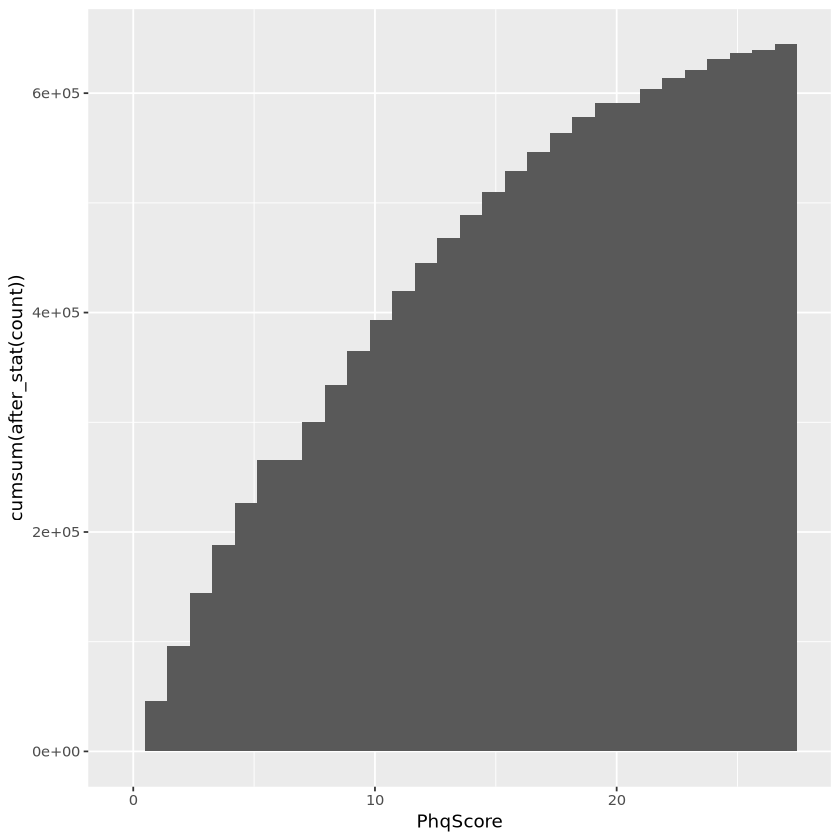

In [164]:
library(ggplot2)
ggplot(phqdfproviders,aes(x=PhqScore)) +
  stat_bin(aes(y=cumsum(after_stat(count))))

# ML models

### Prep ML model 

In [176]:
mlsubset<-phqdfproviders %>% ungroup() %>% slice_sample(n=10000)

In [177]:
mlsubset<-mutate(mlsubset,Depressed=as.factor(Depressed),DepAny=as.factor(DepAny),phqDepressed=as.factor(phqDepressed),phqSevereDepressed=as.factor(phqSevereDepressed))

In [178]:
save(mlsubset,file="mlsubset.RData")

In [179]:
mlsubset %>% count(Depressed)

Depressed,n
<fct>,<int>
0,8113
1,1887


### SVM Model

In [1]:
load(file="/home/ec2-user/SageMaker/mlsubset.RData")

In [4]:
library(dplyr)
library(e1071)

In [ ]:
ls()

In [180]:
#set seed for random number generation
set.seed(10)
mlsubset<-mlsubset %>% ungroup() %>% select(BMI:phqDefDepressed,-X,-`NA`)
#split train and test data 80/20
mlsubset[,"train"] <- ifelse(runif(nrow(mlsubset))<0.8,1,0)
trainset <- mlsubset[mlsubset$train==1,]
testset <- mlsubset[mlsubset$train==0,]
#find “train” column index
trainColNum <- grep("train",names(trainset))
#remove column from train and test sets
trainset <- trainset[,-trainColNum]
testset <- testset[,-trainColNum]



In [181]:
trainset %>% colnames()

[1] "BMI"                   "SystolicBP"            "DiastolicBP"          
 [4] "Audit"                 "Phq2"                  "Diabetes"             
 [7] "Obesity"               "Hyperlipidemia"        "Depressed"            
[10] "Bipolar"               "Anxiety"               "Alcohol"              
[13] "Sleep"                 "SUD"                   "Tobacco"              
[16] "SchizophreniaSpectrum" "Adjustment"            "EatingDisorders"      
[19] "Hypertension"          "PTSD"                  "AdminDate.y"          
[22] "phqDepressed"          "phqSevereDepressed"    "DepAny"               
[25] "Age"                   "FPL"                   "Marital"              
[28] "Gender"                "Race"                  "Rural"                
[31] "Sex"                   "Sexor"                 "L1"                   
[34] "L2"                    "L3"                    "phqDefDepressed"

In [6]:
mlsubset<-mlsubset %>% slice_sample(n=100)

In [182]:
#build default cost model with Admin Date as garbage predictor
library(e1071)
garbageDep.svm<- svm(Depressed~AdminDate.y, data=trainset,type="C-classification", kernel="linear")

In [183]:
summary(garbageDep.svm)


Call:
svm(formula = Depressed ~ AdminDate.y, data = trainset, type = "C-classification", 
    kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  2329

 ( 1165 1164 )


Number of Classes:  2 

Levels: 
 0 1




In [184]:
#build default cost model with Encounter Diagnoses
svm_model<- svm(Depressed~., data=trainset,type="C-classification", kernel="linear")

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
“Variable(s) ‘Diabetes’ and ‘Alcohol’ and ‘Sleep’ and ‘SchizophreniaSpectrum’ and ‘Adjustment’ and ‘EatingDisorders’ and ‘PTSD’ and ‘phqDefDepressed’ constant. Cannot scale data.”


In [185]:
summary(svm_model)


Call:
svm(formula = Depressed ~ ., data = trainset, type = "C-classification", 
    kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  12

 ( 9 3 )


Number of Classes:  2 

Levels: 
 0 1




In [186]:
#training accuracy
pred_train <- predict(svm_model,trainset)
pred_train_garb <- predict(garbageDep.svm,trainset)

In [187]:
mean(pred_train==trainset$Depressed)
mean(pred_train_garb==trainset$Depressed)



Warning message in `==.default`(pred_train, trainset$Depressed):
“longer object length is not a multiple of shorter object length”
Warning message in is.na(e1) | is.na(e2):
“longer object length is not a multiple of shorter object length”


[1] 0.7866482

Warning message in `==.default`(pred_train_garb, trainset$Depressed):
“longer object length is not a multiple of shorter object length”
Warning message in is.na(e1) | is.na(e2):
“longer object length is not a multiple of shorter object length”


[1] 0.8127986

In [ ]:
length(pred_train)
length(trainset$Depressed)

In [188]:
# Confusion matrix
library(caret)
confusionMatrix(data=pred_train,reference=trainset)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




ERROR: Error: `data` and `reference` should be factors with the same levels.


In [ ]:
cm = table(test_set[, 3], pred_train)

In [ ]:
pred_test <- predict(svm_model,testset)
#mean(pred_test==testset$Depressed)


In [ ]:
set.seed(10)
accuracy <- rep(NA,100)
#calculate test accuracy for 100 different partitions
for (i in 1:100){
mlsubset[,"train"] <- ifelse(runif(nrow(mlsubset))<0.8,1,0)
trainColNum <- grep("train",names(mlsubset))
trainset <- mlsubset[mlsubset$train==1,-trainColNum]
testset <- mlsubset[mlsubset$train==0,-trainColNum]
svm_model <- svm(Depressed~ AdminDate, data=trainset, type="C-classification", kernel="linear")
pred_test <- predict(svm_model,testset)
accuracy[i] <- mean(pred_test==testset$Depressed)
}
mean(accuracy)
sd(accuracy)


The models perform too well, even with information that should be basically random like Admin date

## Same as above but trying DepAny

In [ ]:
#build default cost model with DepAny Diagnosis
library(e1071)
svm_model<- svm(DepAny~phqEnc, data=trainset,type="C-classification", kernel="linear")

In [ ]:
svm_model

In [ ]:
#training accuracy
pred_train <- predict(svm_model,trainset)

In [ ]:
mean(pred_train==trainset$DepAny)



In [ ]:
pred_test <- predict(svm_model,testset)
mean(pred_test==testset$DepAny)


In [ ]:

set.seed(10)
accuracy <- rep(NA,100)
#calculate test accuracy for 100 different partitions
for (i in 1:100){
mlsubset[,"train"] <- ifelse(runif(nrow(mlsubset))<0.8,1,0)
trainColNum <- grep("train",names(mlsubset))
trainset <- mlsubset[mlsubset$train==1,-trainColNum]
testset <- mlsubset[mlsubset$train==0,-trainColNum]
svm_model <- svm(DepAny~ AdminDate, data=trainset, type="C-classification", kernel="linear")
pred_test <- predict(svm_model,testset)
accuracy[i] <- mean(pred_test==testset$DepAny)
}
mean(accuracy) #.637
sd(accuracy) #.008



In [ ]:
# test of a full model with features 
mlsubsetSVM<-mlsubset  %>% select(AdminDate,INSTANCE_NUM,HEALTH_SYSTEM_ID,BMI:SEXORIENTATION_CD,DepAny,-`NA`,-train)

In [ ]:
mlsubsetSVM %>% colnames()

In [ ]:
# results of model with no demographic features
set.seed(10)
accuracy <- rep(NA,100)
#calculate test accuracy for 100 different partitions
for (i in 1:100){
mlsubsetSVM[,"train"] <- ifelse(runif(nrow(mlsubsetSVM))<0.8,1,0)
trainColNum <- grep("train",names(mlsubsetSVM))
trainset <- mlsubsetSVM[mlsubsetSVM$train==1,-trainColNum]
testset <- mlsubsetSVM[mlsubsetSVM$train==0,-trainColNum]
svm_model <- svm(DepAny~INSTANCE_NUM+BMI+SystolicBP+DiastolicBP+Diabetes+Obesity+Hyperlipidemia+Hypertension, data=trainset, type="C-classification", kernel="linear")
pred_test <- predict(svm_model,testset)
accuracy[i] <- mean(pred_test==testset$DepAny)
}
mean(accuracy) #.7145
sd(accuracy) #.00922



In [ ]:
#

### Decision Tree

In [ ]:
library(rpart)
#install.packages("rpart.plot")
#install.packages("rattle")

library(rpart.plot)

In [ ]:
Deptree <- rpart(mlsubset$Depressed ~ mlsubset$PhqScore)

In [ ]:
#provider tree with depressed encounter
Deptreeprov <- rpart(mlsubset$Depressed ~ mlsubset$L2+mlsubset$PhqScore)

In [ ]:
#provider tree with depressed any
Deptreeprov <- rpart(mlsubset$DepAny ~ mlsubset$L2+mlsubset$Race)

In [ ]:
Deptreeprov

In [ ]:
rpart.plot(Deptreeprov, cex=.3)

In [ ]:
Depanytree <- rpart(mlsubset$DepAny ~ mlsubset$HOMELESS_CD+mlsubset$HISPANIC_CD+mlsubset$RURAL_CD+mlsubset$CURRENT_FPL_CD+mlsubset$SEXORIENTATION_CD+mlsubset$SEX_CD
                    +mlsubset$RACE_CD+mlsubset$BMI+mlsubset$SystolicBP+mlsubset$DiastolicBP+mlsubset$Obesity+mlsubset$Hyperlipidemia+mlsubset$Hypertension)

In [ ]:
Depanytree

In [ ]:
rpart.plot(Depanytree, cex=.3)

In [ ]:
library(rattle)
fancyRpartPlot(Depanytree, caption = NULL)

pdf(file="depanytree1.pdf")
fancyRpartPlot(Depanytree, caption = NULL,cex=.3)
dev.off()